## Notebook Overview

This notebook explores, models, and interprets accessibility score predictions using structured data. It covers data understanding, model experimentation, tuning, and explainability to evaluate performance across multiple classes.

---

## Contents

### 1. Data Exploration & Preprocessing
- Dataset inspection and basic statistics  
- Class distribution and imbalance analysis  
- Feature understanding and preprocessing steps  

### 2. Baseline Modeling
- Initial model training to establish baseline performance  
- Evaluation using accuracy and classification metrics  

### 3. Model Experimentation
- Training multiple models for comparison  
- Analysis of per-class performance and error patterns  

### 4. Hyperparameter Tuning
- Parameter search to optimize model performance  
- Comparison of tuned vs untuned models  

### 5. Model Evaluation
- Confusion matrices and per-class accuracy analysis  
- Identification of best-performing classes  

### 6. Model Explainability (SHAP)
- Feature importance analysis using SHAP values  
- Class-specific interpretation of model behavior  


## 1. Setup & Data Loading


In [2]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost tensorflowjs textblob nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.40.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.12.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.5.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import re
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
import shap
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use("ggplot")
sns.set_palette("Set2")

In [94]:
df = pd.read_csv('Access_to_Tech_Dataset.csv')

## 2. Data Exploration

In [95]:
print("Data Rows:", df.shape[0], "Data Columns:", df.shape[1])
df.head()

Data Rows: 3524 Data Columns: 17


,id,web_URL_id,domain_category,web_URL,scrape_status,html_file_name,html_file_path,violation_count,violation_name,violation_score,violation_description,violation_description_url,affected_html_elements,violation_category,violation_impact,wcag_reference,supplementary_information
0,700_0,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/buy-from-government\"">How to buy fro...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."
1,700_1,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-banner-is-top-level,3,Ensures the banner landmark is at top level,https://dequeuniversity.com/rules/axe/4.4/land...,"<div class=\usa-banner__header\"" role=\""banner...",Syntax,moderate,['1.3.1 Info and Relationships'],"<div class=\usa-banner__header\"" role=\""banner..."
2,700_2,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-no-duplicate-banner,3,Ensures the document has at most one banner la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],11 <header> or role='banner' elements found:\n...
3,700_3,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-unique,3,Landmarks should have a unique role or role/la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],Role 'search' found 2 times:\n<form accept-cha...
4,701_0,701,Government and Public Services,https://www.usa.gov/benefits,scraped,www_usa_gov_benefits.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/food-help\"">Learn about food assista...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."


In [96]:
## Data Overview

df.info()
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         3524 non-null   object
 1   web_URL_id                 3524 non-null   int64 
 2   domain_category            3524 non-null   object
 3   web_URL                    3524 non-null   object
 4   scrape_status              3524 non-null   object
 5   html_file_name             3524 non-null   object
 6   html_file_path             3524 non-null   object
 7   violation_count            3524 non-null   int64 
 8   violation_name             3524 non-null   object
 9   violation_score            3524 non-null   int64 
 10  violation_description      3524 non-null   object
 11  violation_description_url  3523 non-null   object
 12  affected_html_elements     3472 non-null   object
 13  violation_category         3520 non-null   object
 14  violatio

np.int64(0)

### Initial Observations
- Each row represents a **single accessibility violation instance**
- Dataset includes:
  - Site metadata
  - Violation severity & score
  - HTML snippet context
This structure supports both **classification** and **regression** modeling.


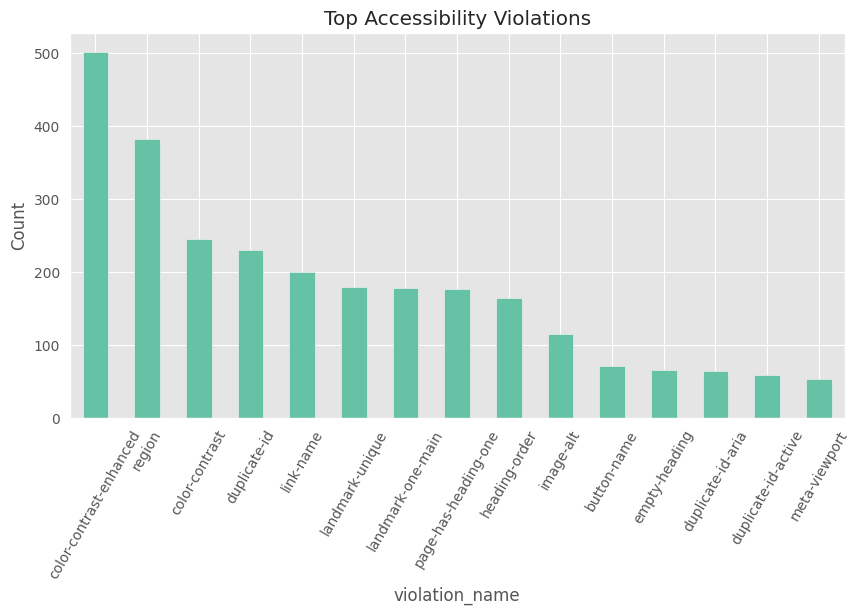

In [97]:
## Distribution of Violations

top_violations = df["violation_name"].value_counts().head(15)

plt.figure(figsize=(10,5))
top_violations.plot(kind="bar")
plt.title("Top Accessibility Violations")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.show()


A small subset of violations dominates the web →  This makes **targeted ML prediction feasible**.


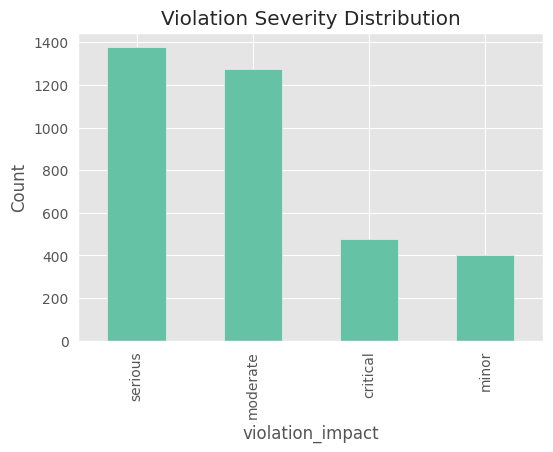

In [98]:
#Severity Distibution

plt.figure(figsize=(6,4))
df["violation_impact"].value_counts().plot(kind="bar")
plt.title("Violation Severity Distribution")
plt.ylabel("Count")
plt.show()

Serious and moderate violations form the majority →  **Real-world accessibility risk is widespread.**

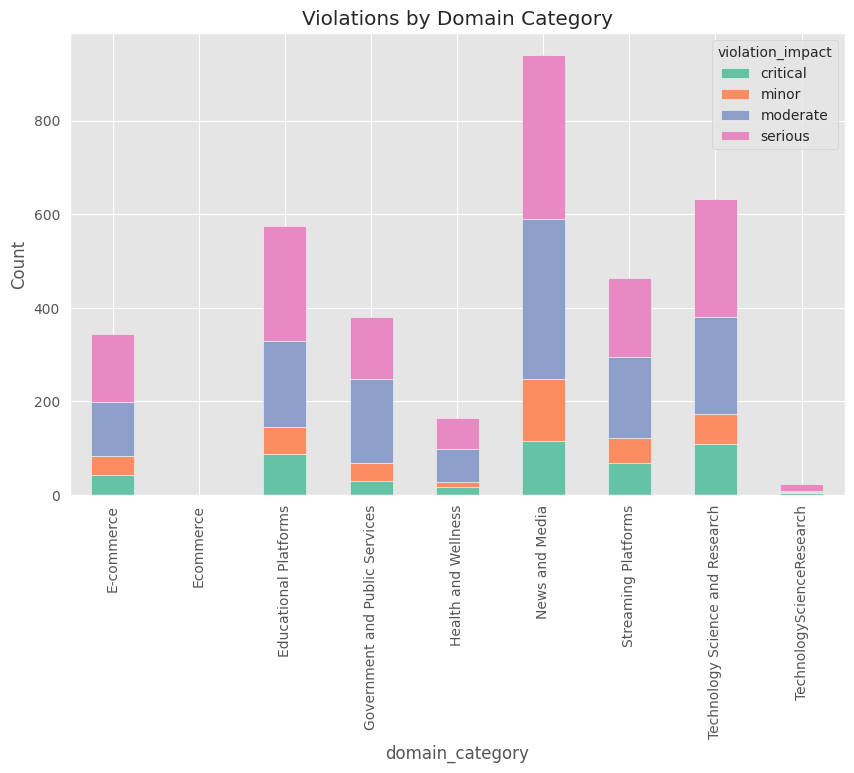

In [99]:
## Violation by Domain

domain_severity = pd.crosstab(df["domain_category"], df["violation_impact"])

domain_severity.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Violations by Domain Category")
plt.ylabel("Count")
plt.show()


Different domains exhibit distinct severity patterns →  **Domain category is a strong ML feature.**

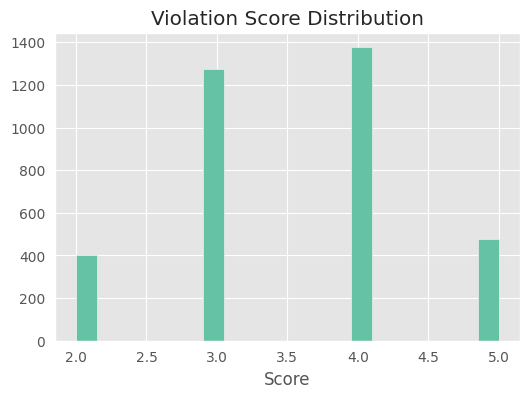

In [100]:
## Violation Score Distibution

plt.figure(figsize=(6,4))
df["violation_score"].hist(bins=20)
plt.title("Violation Score Distribution")
plt.xlabel("Score")
plt.show()

Score distribution determines:
- Whether regression is meaningful
- Thresholds for accessibility scoring


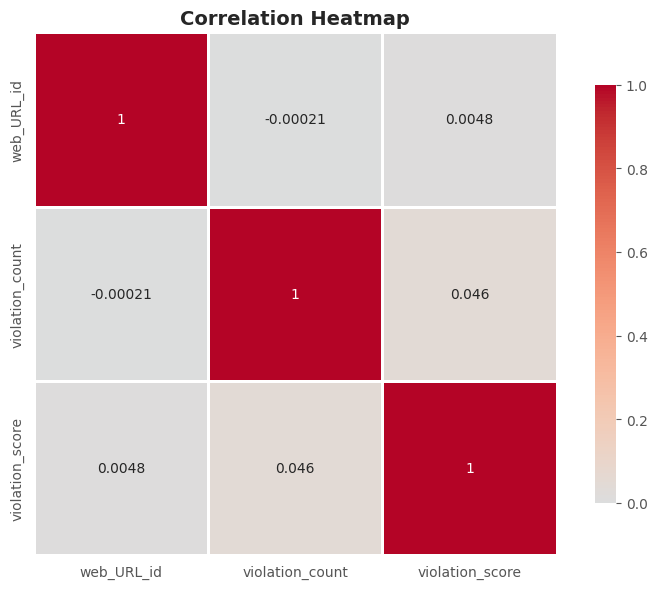

In [102]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

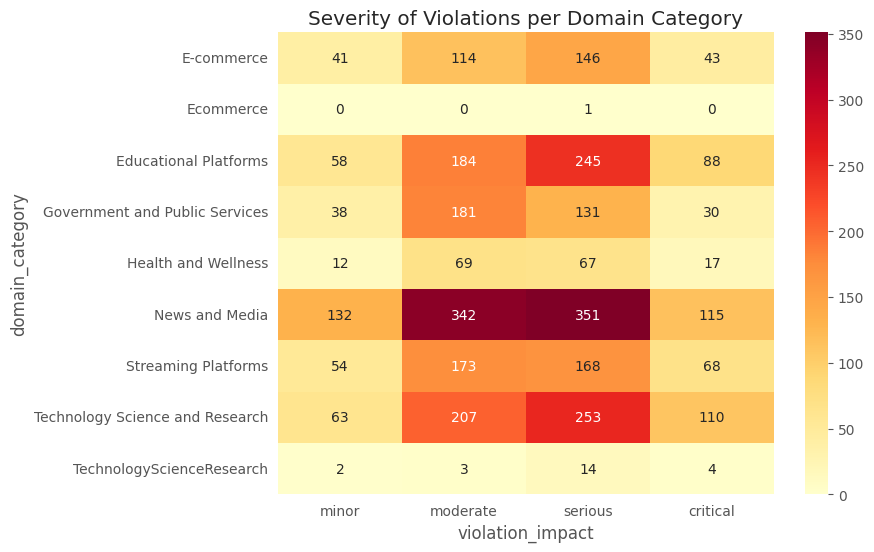

In [35]:
pivot_df = df.groupby(['domain_category', 'violation_impact']).size().unstack(fill_value=0)
cols = ['minor', 'moderate', 'serious', 'critical']
pivot_df = pivot_df[[c for c in cols if c in pivot_df.columns]]

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlOrRd")
plt.title('Severity of Violations per Domain Category')
plt.show()

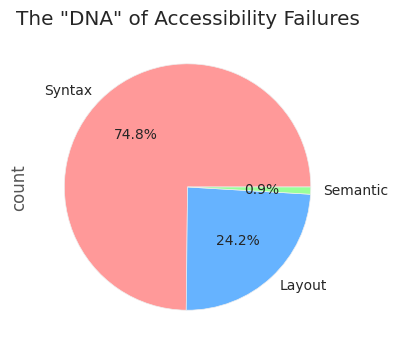

In [36]:
plt.figure(figsize=(4, 4))
df['violation_category'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('The "DNA" of Accessibility Failures')
plt.show()

## Data Cleaning and Feature Engineering

In [105]:
for col in ['violation_name', 'violation_category', 'domain_category', 'violation_impact']:
    df[col] = df[col].str.strip().str.lower()

impact_map = {'minor': 1, 'moderate': 2, 'serious': 3, 'critical': 4}
df['impact_numeric'] = df['violation_impact'].map(impact_map).fillna(1)
df['severity_score'] = df['impact_numeric'] / 4.0


In [106]:
def extract_everything(row):
    html = str(row['affected_html_elements']).lower()
    supp = str(row['supplementary_information']).lower()
    v_name = str(row['violation_name']).lower()
    wcag = str(row['wcag_reference']).upper()

    tag_match = re.search(r'<([a-zA-Z0-9]+)', html)
    tag = tag_match.group(1) if tag_match else 'unknown'

    alt_match = re.search(r'alt=["\'](.*?)["\']', html)
    alt_content = alt_match.group(1).strip() if alt_match else ""

    redundant_pat = r'(image of|photo of|picture of|link to|click here|button|graphic of)'
    placeholder_set = {'alt', 'description', 'label', 'placeholder', 'none', 'image', 'spacer', 'icon', 'dot'}

    cr_match = re.search(r"contrastratio':\s*([0-9.]+)", supp)
    fs_match = re.search(r"fontsize':\s*['\"]([0-9.]+)", supp)

    return pd.Series({
        'html_tag': tag,
        'snippet_len': len(html),
        'snippet_word_count': len(html.split()),
        'tag_count': html.count('<'),
        'is_button_or_link': 1 if any(x in html for x in ['<a', '<button']) else 0,
        'has_id': 1 if 'id=' in html else 0,
        'has_class': 1 if 'class=' in html else 0,
        'has_role_attr': 1 if 'role=' in html else 0,
        'has_tabindex': 1 if 'tabindex=' in html else 0,

        'is_img_or_svg': 1 if any(x in html for x in ['<img', '<svg']) else 0,
        'has_alt_attr': 1 if 'alt=' in html else 0,
        'is_alt_empty': 1 if (alt_content == "" and 'alt=' in html) else 0,
        'alt_word_count': len(alt_content.split()),
        'alt_is_generic': 1 if alt_content in placeholder_set else 0,
        'alt_is_filename': 1 if re.search(r'\.(jpg|png|gif|jpeg|svg|webp)$', alt_content) else 0,
        'has_redundant_prefix': 1 if re.search(redundant_pat, html) else 0,
        'is_aria_hidden': 1 if 'aria-hidden="true"' in html else 0,
        'has_aria_label': 1 if 'aria-label=' in html else 0,

        'contrast_ratio': float(cr_match.group(1)) if cr_match else np.nan,
        'font_size': float(fs_match.group(1)) if fs_match else np.nan,
        'is_aria_related': 1 if ('aria' in v_name or 'aria' in supp) else 0,
        'aria_density': supp.count('aria-'),
        'supp_info_len': len(supp),

        'wcag_level': 3 if 'AAA' in wcag else (2 if 'AA' in wcag else (1 if 'A' in wcag else 0))
    })

In [107]:

feature_df = df.apply(extract_all_features if 'extract_all_features' in locals() else extract_everything, axis=1)
df = pd.concat([df, feature_df], axis=1)

le = LabelEncoder()
df['domain_encoded'] = le.fit_transform(df['domain_category'])
df['url_depth'] = df['web_URL'].str.count('/') - 2
df['url_len'] = df['web_URL'].str.len()
df['is_gov'] = df['web_URL'].str.contains('.gov', case=False, na=False).astype(int)
df['is_edu'] = df['web_URL'].str.contains('.edu', case=False, na=False).astype(int)
df['is_org'] = df['web_URL'].str.contains('.org', case=False, na=False).astype(int)

#Final Export
df.to_csv('master_accessibility_features_final.csv', index=False)

print("Exhaustive Pre-processing Complete!")
print(f"Features ready for ML: {len(feature_df.columns) + 6} (Technical + Domain + URL)")
print(f"Dataset Shape: {df.shape}")

Exhaustive Pre-processing Complete!
Features ready for ML: 30 (Technical + Domain + URL)
Dataset Shape: (3524, 49)


In [108]:
len(df.groupby('violation_name')['violation_category'].value_counts())

90

In [109]:
df.head()

,id,web_URL_id,domain_category,web_URL,scrape_status,html_file_name,html_file_path,violation_count,violation_name,violation_score,...,is_aria_related,aria_density,supp_info_len,wcag_level,domain_encoded,url_depth,url_len,is_gov,is_edu,is_org
0,700_0,700,government and public services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,...,0,0,196,1,3,1,32,1,0,0
1,700_1,700,government and public services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-banner-is-top-level,3,...,1,3,1315,1,3,1,32,1,0,0
2,700_2,700,government and public services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-no-duplicate-banner,3,...,1,12,13317,1,3,1,32,1,0,0
3,700_3,700,government and public services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-unique,3,...,0,0,1692,1,3,1,32,1,0,0
4,701_0,701,government and public services,https://www.usa.gov/benefits,scraped,www_usa_gov_benefits.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,...,0,0,196,1,3,1,28,1,0,0


### Fetch Features from Parsing HTML

In [110]:
def extract_html_features(html):
    # Convert NaN to empty string
    if pd.isna(html):
        html = ""

    soup = BeautifulSoup(str(html), "html.parser")

    return {
        "num_links": len(soup.find_all('a')),
        "num_images": len(soup.find_all(['img','svg'])),
        "num_buttons": len(soup.find_all('button')),
        "num_inputs": len(soup.find_all('input')),
        "num_lists": len(soup.find_all(['ul','ol','li'])),
        "num_headings": len(soup.find_all(['h1','h2','h3','h4','h5','h6'])),
        "has_form": int(soup.find('form') is not None),
        "num_divs": len(soup.find_all('div')),
        "num_spans": len(soup.find_all('span')),
        "avg_text_len_per_tag": np.mean([len(t.get_text()) for t in soup.find_all()]) if soup.find_all() else 0,
        "has_inline_style": int(soup.find(attrs={'style':True}) is not None),
        "has_script_or_style": int(soup.find(['script','style']) is not None),
    }

html_features = df['supplementary_information'].apply(extract_html_features)
html_features_df = pd.DataFrame(list(html_features))

# Merge with main dataframe
df = pd.concat([df, html_features_df], axis=1)

# Quick check
print("Added HTML parser features. Shape now:", df.shape)
print(df.columns[-12:])  # print last 12 added columns


Added HTML parser features. Shape now: (3524, 61)
Index(['num_links', 'num_images', 'num_buttons', 'num_inputs', 'num_lists',
       'num_headings', 'has_form', 'num_divs', 'num_spans',
       'avg_text_len_per_tag', 'has_inline_style', 'has_script_or_style'],
      dtype='object')


In [111]:
#Encode categorical features
le_violation = LabelEncoder()
df['violation_id_enc'] = le_violation.fit_transform(df['violation_name'].astype(str))

le_tag = LabelEncoder()
df['tag_enc'] = le_tag.fit_transform(df['html_tag'].astype(str))

#clean target cariable
df = df.dropna(subset=['violation_category'])
df['violation_category'] = LabelEncoder().fit_transform(df['violation_category'])

In [113]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


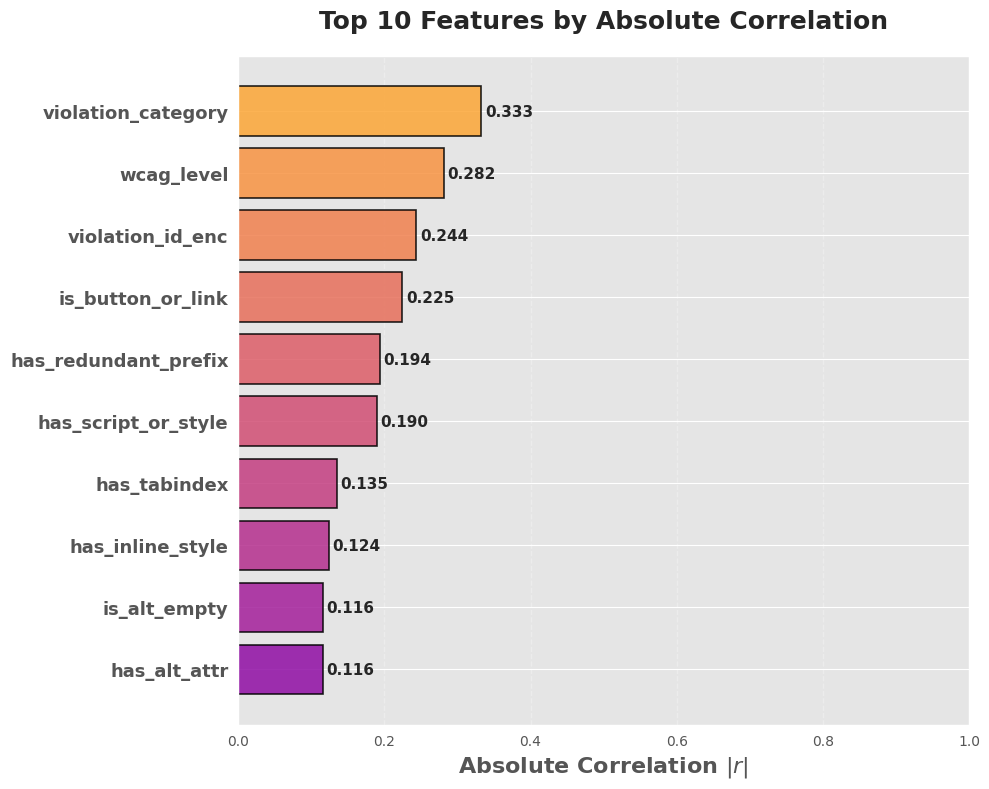

violation_category      0.332542
wcag_level              0.281709
violation_id_enc        0.243551
is_button_or_link       0.224611
has_redundant_prefix    0.193928
has_script_or_style     0.189644
has_tabindex            0.134856
has_inline_style        0.124253
is_alt_empty            0.115831
has_alt_attr            0.115831
dtype: float64


In [122]:
exclude_cols = ['severity_score', 'impact_numeric', 'violation_score']
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

target_corr = df[numeric_cols].corrwith(df['violation_score']).abs().dropna()
target_corr = target_corr.sort_values(ascending=True).tail(10)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.plasma(np.linspace(0.3, 0.8, len(target_corr)))
bars = ax.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)

ax.set_yticks(range(len(target_corr)))
ax.set_yticklabels(target_corr.index, fontsize=13, fontweight='bold')
ax.set_xlabel(r'Absolute Correlation $|r|$', fontsize=16, fontweight='bold')
ax.set_title(r'Top 10 Features by Absolute Correlation', fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)

for i, val in enumerate(target_corr.values):
    ax.text(val + 0.005, i, f'{val:.3f}', va='center', ha='left', fontsize=11, fontweight='bold')

ax.set_xlim(0, 1)
plt.tight_layout()
plt.savefig('top_10_absolute_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(target_corr.sort_values(ascending=False))

In [49]:
# Listing features
features = [
    # Original features
    'impact_numeric', 'tag_enc', 'snippet_len',
    'has_aria_label', 'has_role_attr', 'is_button_or_link', 'is_img_or_svg',

    # HTML parser features
    'num_links', 'num_images', 'num_buttons', 'num_inputs', 'num_lists',
    'num_headings', 'has_form', 'num_divs', 'num_spans',
    'avg_text_len_per_tag', 'has_inline_style', 'has_script_or_style'
]

In [50]:
available_features = [f for f in features if f in df.columns]

## Classification Model to predict the type of accessibility violation based on HTML code snippets or metadata.

In [51]:
X = df[available_features]
y = df['violation_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [52]:
df['violation_category'].corr(df['violation_id_enc'])

np.float64(0.3807469488368568)

In [53]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# --- Evaluation ---
y_pred = xgb_clf.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.9233
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       171
           1       0.25      0.17      0.20         6
           2       0.96      0.94      0.95       527

    accuracy                           0.92       704
   macro avg       0.68      0.67      0.67       704
weighted avg       0.92      0.92      0.92       704



XGB Classifier predicts violation_category with 0.93 accuracy


##XGB Classifier to predict Violation Score

In [63]:

print("Column names:")
print(df.columns.tolist())

print("\n")
print("Sample of data:")
print(df.head())

print("\n")
print("Check for violation_score column:")
if 'violation_score' in df.columns:
    print("✓ Found violation_score")
    print(f"Unique scores: {sorted(df['violation_score'].unique())}")
    print(f"Score distribution:\n{df['violation_score'].value_counts().sort_index()}")
else:
    # Look for similar columns
    score_cols = [col for col in df.columns if 'score' in col.lower()]
    print(f"Columns with 'score': {score_cols}")

print("\n")
print("Data types:")
print(df.dtypes)

Column names:
['id', 'web_URL_id', 'domain_category', 'web_URL', 'scrape_status', 'html_file_name', 'html_file_path', 'violation_count', 'violation_name', 'violation_score', 'violation_description', 'violation_description_url', 'affected_html_elements', 'violation_category', 'violation_impact', 'wcag_reference', 'supplementary_information', 'impact_numeric', 'severity_score', 'html_tag', 'snippet_len', 'snippet_word_count', 'tag_count', 'is_button_or_link', 'has_id', 'has_class', 'has_role_attr', 'has_tabindex', 'is_img_or_svg', 'has_alt_attr', 'is_alt_empty', 'alt_word_count', 'alt_is_generic', 'alt_is_filename', 'has_redundant_prefix', 'is_aria_hidden', 'has_aria_label', 'contrast_ratio', 'font_size', 'is_aria_related', 'aria_density', 'supp_info_len', 'wcag_level', 'domain_encoded', 'url_depth', 'url_len', 'is_gov', 'is_edu', 'is_org', 'num_links', 'num_images', 'num_buttons', 'num_inputs', 'num_lists', 'num_headings', 'has_form', 'num_divs', 'num_spans', 'avg_text_len_per_tag', 'ha

In [81]:
features = [
    # Encoded categorical
    # 'violation_id_enc',
    'tag_enc',
    # 'impact_numeric',

    # HTML snippet features
    'snippet_len',
    'word_count',
    'tag_count',

    # Boolean features
    'is_button_or_link',
    'is_img_or_svg',
    'has_alt_attr',
    'has_aria_label',
    'has_role_attr',
    'is_aria_related',

    # Numeric features
    'contrast_ratio',
    'font_size',

    # HTML parser features
    'num_links', 'num_images', 'num_buttons', 'num_inputs', 'num_lists',
    'num_headings', 'has_form', 'num_divs', 'num_spans',
    'avg_text_len_per_tag', 'has_inline_style', 'has_script_or_style'
]

available_features = [f for f in features if f in df.columns]

In [82]:

# Prepare data
X = df[available_features].fillna(0)  # Fill NaN values with 0
y = df['violation_score']


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [83]:
feature_corr = X_train.copy()
feature_corr['violation_score'] = y_train.values

correlation_with_target = feature_corr.corr()['violation_score'].drop('violation_score').sort_values(ascending=False)
print(correlation_with_target)

contrast_ratio          0.256039
font_size               0.249516
is_button_or_link       0.214282
snippet_len             0.089278
tag_count               0.072682
has_role_attr           0.056906
is_aria_related         0.043288
has_aria_label          0.039080
is_img_or_svg           0.020756
num_inputs             -0.044411
tag_enc                -0.056788
num_buttons            -0.065170
num_spans              -0.069858
num_lists              -0.071587
avg_text_len_per_tag   -0.071888
num_links              -0.078335
has_form               -0.082311
num_divs               -0.090335
num_images             -0.105618
has_alt_attr           -0.108709
num_headings           -0.112739
has_inline_style       -0.115679
has_script_or_style    -0.170480
Name: violation_score, dtype: float64


In [84]:
# Map scores
score_mapping = {2:0, 3:1, 4:2, 5:3}
reverse_mapping = {0:2, 1:3, 2:4, 3:5}

y_train_mapped = y_train.map(score_mapping)
y_val_mapped = y_val.map(score_mapping)
y_test_mapped = y_test.map(score_mapping)

SMOTE FOR OVERSAMPLING

In [85]:
# SMOTE on training
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_mapped)

Random Forest Classifier

In [88]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_smote, y_train_smote)

y_pred_mapped = rf_clf.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(reverse_mapping)


print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8068
              precision    recall  f1-score   support

           2       0.57      0.74      0.64        80
           3       0.87      0.88      0.88       254
           4       0.97      0.75      0.84       275
           5       0.61      0.84      0.70        95

    accuracy                           0.81       704
   macro avg       0.75      0.80      0.77       704
weighted avg       0.84      0.81      0.81       704



XG Boost Classifier

In [70]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',  # probabilities needed for SHAP
    num_class=len(y_train.unique()),
    random_state=42,
    eval_metric='mlogloss'
)
xgb_clf.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, num_class=4, ...)

In [71]:
y_pred_mapped = xgb_clf.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(reverse_mapping)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    labels=[2, 3, 4, 5],
    target_names=['Score 2', 'Score 3', 'Score 4', 'Score 5']
))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=[2, 3, 4, 5])
print(cm)
print("\nRows = Actual Score, Columns = Predicted Score")

# Per-class accuracy
print("\nPer-Score Performance:")
for i, score in enumerate([2, 3, 4, 5]):
    class_total = cm[i].sum()
    class_correct = cm[i][i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"  Score {score}: {class_correct}/{class_total} = {class_acc:.2%}")



Test Accuracy: 0.8494

Classification Report:
              precision    recall  f1-score   support

     Score 2       0.73      0.70      0.71        80
     Score 3       0.89      0.93      0.91       254
     Score 4       0.92      0.83      0.87       275
     Score 5       0.67      0.80      0.73        95

    accuracy                           0.85       704
   macro avg       0.80      0.82      0.81       704
weighted avg       0.86      0.85      0.85       704


Confusion Matrix:
[[ 56   4   7  13]
 [  5 237   7   5]
 [  6  21 229  19]
 [ 10   3   6  76]]

Rows = Actual Score, Columns = Predicted Score

Per-Score Performance:
  Score 2: 56/80 = 70.00%
  Score 3: 237/254 = 93.31%
  Score 4: 229/275 = 83.27%
  Score 5: 76/95 = 80.00%


##HYPERPARAMETER TUNING

In [73]:
param_grid = {
    'n_estimators':[100,150,200],
    'max_depth':[4,6,8],
    'learning_rate':[0.05,0.1,0.2],
    'subsample':[0.8,1],
    'colsample_bytree':[0.8,1]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    random_state=42,
    eval_metric='mlogloss'
)

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_smote, y_train_smote)

# 5. Best model
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1}


### SHAP VALUES

In [74]:
def best_class_shap(xgb_clf, X_test, y_test, reverse_mapping, target_classes=[2,3,4,5]):


    y_pred_mapped = xgb_clf.predict(X_test)
    y_pred = pd.Series(y_pred_mapped).map(reverse_mapping)

    acc = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(
        y_test,
        y_pred,
        labels=target_classes,
        target_names=[f'Score {c}' for c in target_classes]
    ))

    cm = confusion_matrix(y_test, y_pred, labels=target_classes)
    print("\nConfusion Matrix:")
    print(cm)
    print("\nRows = Actual Score, Columns = Predicted Score")

    # Per-class accuracy
    class_acc_dict = {}
    print("\nPer-Score Performance:")
    for i, score in enumerate(target_classes):
        class_total = cm[i].sum()
        class_correct = cm[i][i]
        class_acc = class_correct / class_total if class_total > 0 else 0
        class_acc_dict[score] = class_acc
        print(f"  Score {score}: {class_correct}/{class_total} = {class_acc:.2%}")

    # Best class
    best_class = max(class_acc_dict, key=class_acc_dict.get)
    class_acc = class_acc_dict[best_class]
    print(f"\nBest class: Score {best_class} with accuracy {class_acc:.2%}")

    # SHAP values for that class only
    explainer = shap.TreeExplainer(xgb_clf)
    shap_values_obj = explainer(X_test)

    shap_array = shap_values_obj.values
    feature_names = X_test.columns

    class_idx = list(reverse_mapping.keys())[list(reverse_mapping.values()).index(best_class)]

    # Mean absolute SHAP values for this class
    shap_values_class = np.abs(shap_array[:, :, class_idx]).mean(axis=0)
    shap_values_df = pd.DataFrame(shap_values_class, index=feature_names, columns=[f'Score {best_class}'])

    return best_class, class_acc, shap_values_df

In [75]:
best_class, best_acc, best_shap_df = best_class_shap(
    best_model, X_test, y_test, reverse_mapping
)
print("\nTop SHAP values for best class:")
print(best_shap_df.sort_values(by=f'Score {best_class}', ascending=False))


Test Accuracy: 0.8523

Classification Report:
              precision    recall  f1-score   support

     Score 2       0.64      0.70      0.67        80
     Score 3       0.89      0.93      0.91       254
     Score 4       0.93      0.84      0.88       275
     Score 5       0.74      0.81      0.77        95

    accuracy                           0.85       704
   macro avg       0.80      0.82      0.81       704
weighted avg       0.86      0.85      0.85       704


Confusion Matrix:
[[ 56   5   5  14]
 [  8 236   6   4]
 [ 14  21 231   9]
 [  9   2   7  77]]

Rows = Actual Score, Columns = Predicted Score

Per-Score Performance:
  Score 2: 56/80 = 70.00%
  Score 3: 236/254 = 92.91%
  Score 4: 231/275 = 84.00%
  Score 5: 77/95 = 81.05%

Best class: Score 3 with accuracy 92.91%

Top SHAP values for best class:
                       Score 3
tag_enc               1.414594
snippet_len           0.904485
is_aria_related       0.485056
contrast_ratio        0.459775
tag_count   

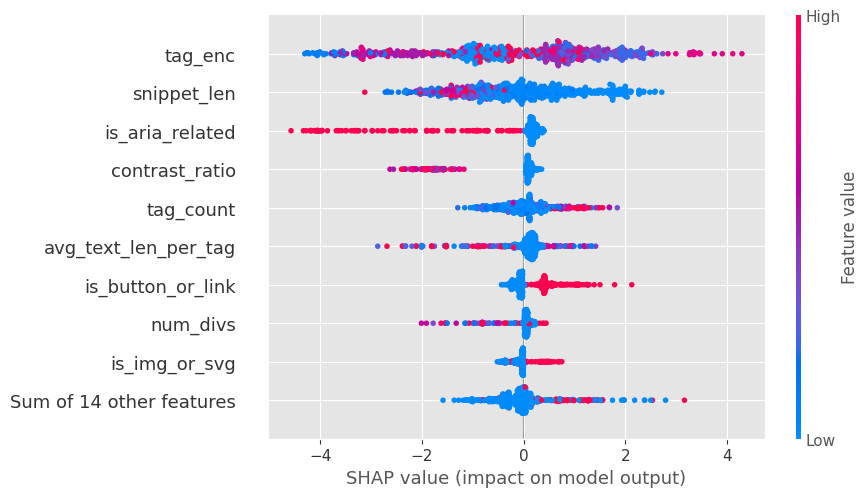

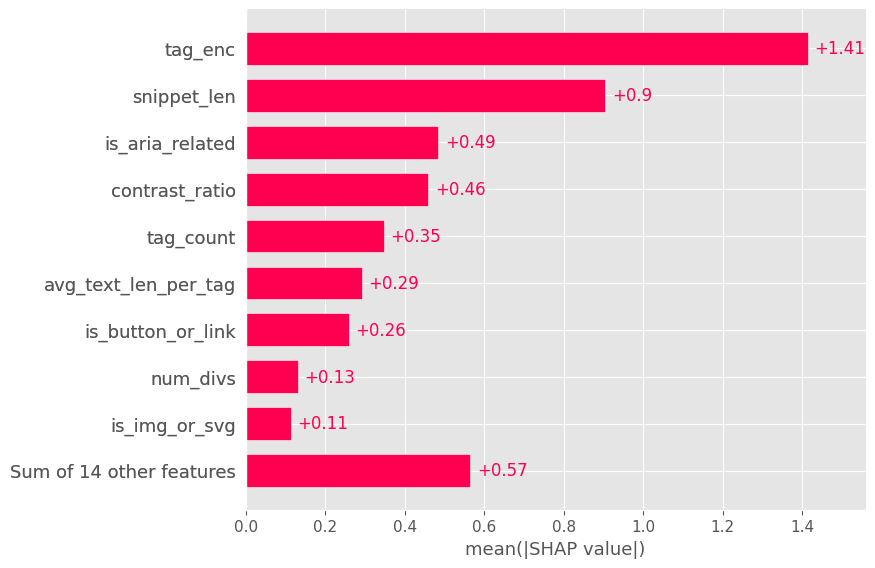

In [79]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

class_idx = list(reverse_mapping.keys())[list(reverse_mapping.values()).index(best_class)]

# Beeswarm plot
shap.plots.beeswarm(
    shap_values[:, :, class_idx],
    show=True
)

# Bar plot (mean |SHAP|)
shap.plots.bar(
    shap_values[:, :, class_idx],
    show=True
)
